- Title: Bayesian GPS
- Subtitle: A Bayesian take on GPS esque maths
- Date: 2019-05-23 13:20
- Category: bayesian, interviews
- Tags: python, bayesian, gps, interviews
- Authors: Varun Nayyar
    


# Question


I call this the Bayesian GPS problem. In it's a simplified form, we're given a 2d plane and a series of distance estimates between ourselves and each tower. We know the location of each tower, but the measurements aren't super accurate. Given a few thousand of these measurements, we want to know where we are on this 2d plane.

# My Solution

## The Likelihood

We consider the error circle in 2 dimensions (I've drawn one a bit below). Intuitively it is a
circle centereed at some co-ordinate $x$ with a distribution of it's
radius $r$ for values of $\theta$. For the sake of simplicity, we
assume that $\theta\sim Uniform(0,2\pi)$, but this is not necessary.

More formally, using polar co-ordinate notation, we can define the
distribution in terms of the radius around center $x$

\begin{align*}
\theta\sim & U(0,2\pi)\\
d|r_{i}\sim & Normal(r_{i},(0.1r_{i})^{2})
\end{align*}

The choice of d's variance is a bit contentious, but it makes this method quite adaptable.
We could quite easily choose a fixed value for each measurement, but generally measurement error tends to be 
proportional to measurements. 

Note that $\theta$ and $d$ are independent of each other . Since
$\theta$ is chosen to be uniform, we can actually drop consideration
of this value since it's just a constant normalisation value. 

\begin{align*}
f(\theta) & =1/2\pi\mbox{ for}\theta\in[0,2\pi]
\end{align*}

Now, for location y and measurement point $x_{i}$, d is given by
the L2 norm, i.e.
\begin{align*}
d= & \sqrt{(y1-x1_{i})^{2}-(y2-x2_{i})^{2}}
\end{align*}
Now we for a location y and observation of $x_{i}$,$r_{i}$, and
estimated sd $rsd_{i}$the probability of being at location
y is given by 
\begin{align*}
p(y|x_{i},r_{i})\propto & \phi((d-r_{i})/(rsd_{i}))
\end{align*}

Where $\phi$ is the standard normal rv.

Intuitively, we convert the $x_{i}$ and y into a distance and then
calculate the likelihood of seeing such a radius for our chosen distribution.
The phi is the standard normal pdf but the above can be read $f(d|r_{i},rsd_{i})$
where$f\sim Norm(r_{i},rsd_{i})$. Since$\theta$ doesn't matter in
this case, we've dropped it, but had we chosen a different distribution
(say wrapped normal), we would have had to calculate $\theta$ and
it's probability of being at this point.

Hence the likelihood function for dataset X can be be given as 
\begin{align*}
ll(y|X)\propto & \sum_{\forall X}\frac{1}{|X|}p(y|x_{i},r_{i})\\
\propto & \sum_{\forall X}p(y|x_{i},r_{i})\\
= & \sum_{\forall X}\phi\left(\frac{d-r_{i}}{rsd_{i}}\right)
\end{align*}
Note that we've chosen to give each observation an equal weighting
as depicted with the $\frac{1}{|X|}$term, which we can then drop
since it's not dependent on the data. This is the un-normalised likelihood
function which we can calculate for each y. The above equation is
very similar to a mixture model equation. Due to the exponential and
square root, this would not provide a closed form solution for the
MLE. However it is differentiable and thus the problem can be converted
into a simple optimisation problem to find the MLE.


## The Posterior

However, the above is effectively a mixture model with each parameter
known. These can be somewhat pathological likelihood's with many multiple
peaks that provide a lot of dependency on the initialisation conditions.
Imagine an erroneous measurement far away from the true peak, and our hill climb could end up spinning around
that location. It's not a robust approach. Instead, we realise that
we can calculate a posterior and with a flat prior the MLE and the
Maximum a Posteriori (MAP) value coincide. For 2000 observations and
2 dimensions, this is not likely to be a problem, but would be for
larger dims and smaller datasets, this would be more of a problem.

Additionally, I finished the MAP code before I realised I could solve
the above equation for the MLE. I could also use auto-differentiation packages
to solve this problem, but I think brute force is underrated as a technique.
I think in a 2d problem, brute force is a reasonable solution when everything else
is a magnitude mroe difficult. Typically, we would run an MCMC and find
the maximum posteriori by finding the most commonly occurring value, but I 
don't think the overhead is worth it.

Having looking at the data, I choose priors $(x,y)\in X$ are independent and $p(x)\sim U(80,140)$,
$p(y)\sim U(130,190)$. Again, we use this value because it simplifies
the maths significantly. (Also gives me another thing I can potentially publish!)


## The Code

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import norm

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
%matplotlib inline

def get_data():
    """ read and augment the rsd"""
    data = pd.read_csv("../resources/data-1.csv", names=["x", "y", "r"], skiprows=1)
    data["rsd"] = 0.1 * data.r
    return data


def circle_prior(dat):
    """
    Produces a bunch of circles for each
    observation in the data and plots.
    Useful to build prior of the location to search in.
    """
    from matplotlib import pyplot as plt
    from matplotlib import patches as mpatches

    fig = plt.figure(figsize = (12,10))
    ax = fig.gca()

    for i, row in dat.iterrows():
        cr = mpatches.Circle([row.x, row.y], row.r, fill=False, alpha=0.1)
        ax.add_patch(cr)
        
    ax.set_ylim((dat.y.min(),dat.y.max()))
    ax.set_xlim((dat.x.min(), dat.x.max()))
    plt.show()


def plot_posterior(posterior):
    """
    Produce a heatmap of posterior.
    xticks and yticks are assumed to be 
    standard prior 
    """
    from matplotlib import pyplot as plt
    plt.figure(figsize=(14,12))
    plt.title("Posterior")
    plt.xlabel("X")
    plt.ylabel("Y")
    ax = sns.heatmap(posterior, xticklabels = list(range(80, 140)), yticklabels=list(range(130,190)))
    ax.invert_yaxis()
    plt.show()


def ll(y, dat):
    """
    The un-normalised likelihood from the model described.
    For 2d input y and given 2d location x and distance r.
        ll = sum phi( (r - d) / rsd)
        where d = sqrt( (y1-x1)^2 + (y2-x2)^2)

    See readme for more information on the derivation.

    Args:
        y (tuple): location in (x,y) whose likelihood we wish to calculate
        dat (pd.DataFrame): x, y, r, rsd
            Dataset containing the x,y, and r data as well as the
            augmented sd value.

    Returns:
        float: likelihood at y for given dataset

    """
    # calculate distance from y as a radius
    d = np.sqrt((y[0] - dat.x) ** 2 + (y[1] - dat.y) ** 2)
    zs = (dat.r - d) / dat.rsd
    return np.sum(norm.pdf(zs))


def main(data):

    # set the variance of r to be 10% of the measurement
    # this can be changed as required

    # from an inspection of the circle diagrams,
    # we're quite sure our location is in between
    # x=(80,140), y=(130,190).
    # This is equivalent to a uniform prior on these regions.

    # We could use MCMC on the  likelihood function, however, given
    # that we need to look at integer values only and our prior is 60x60=3600
    # we can achieve this with just a grid search.
    # In the general case, this can be done for min and max of x and y

    # change as required
    xpriorRange = (80, 140)
    ypriorRange = (130, 190)

    # convenience
    st = (xpriorRange[0], ypriorRange[0])
    # pre-allocate posterior
    posterior = np.zeros((60, 60))

    # for loops are slow and should be avoided
    # however for this grid, this is small enough to not be a concern.
    for x in range(*xpriorRange):
        for y in range(*ypriorRange):
            posterior[x - st[0]][y - st[1]] = ll((x, y), data)

    # find the maximum a posteriori
    maxap = np.argmax(posterior)
    ind = np.unravel_index(maxap, posterior.shape)

    # remember the shape needs to be updated since we start at st
    location = (ind[0] + st[0], ind[1] + st[1])
    return posterior, location


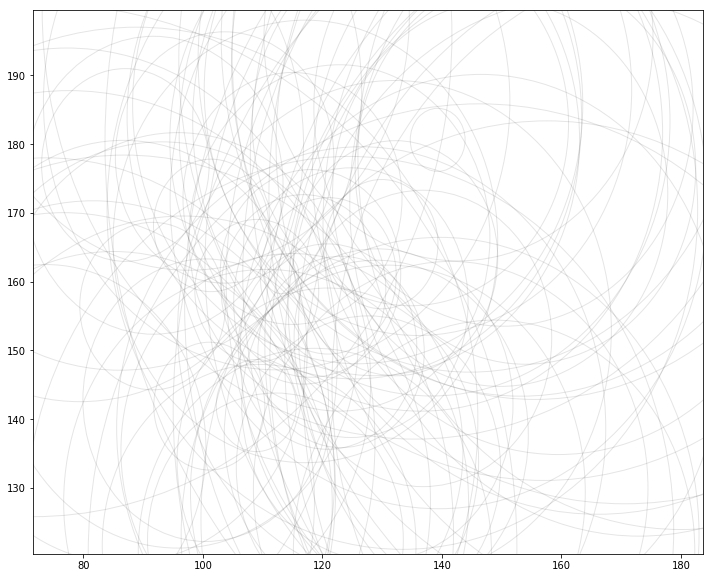

In [17]:
# let's draw the circle's. Let's keep this to 100 circles
# Hopefully this shows you why the prior has been chosen
gps_data = get_data()
circle_prior(gps_data.head(100))

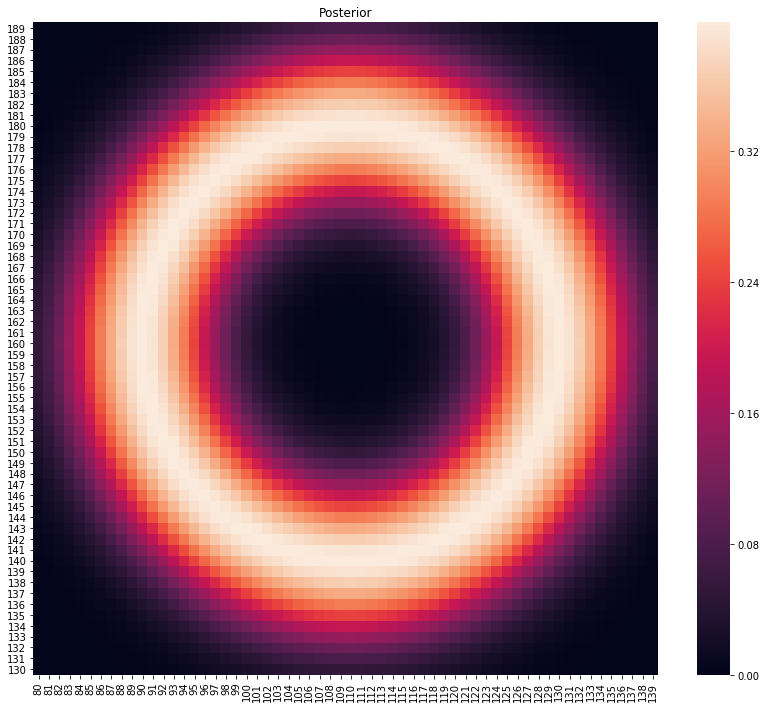

In [10]:
# let's see what the error circle looks like
testdat = pd.DataFrame([[110, 160, 20, 5]], columns=['x', 'y', 'r', 'rsd'])
p, lo = main(testdat)
plot_posterior(p)

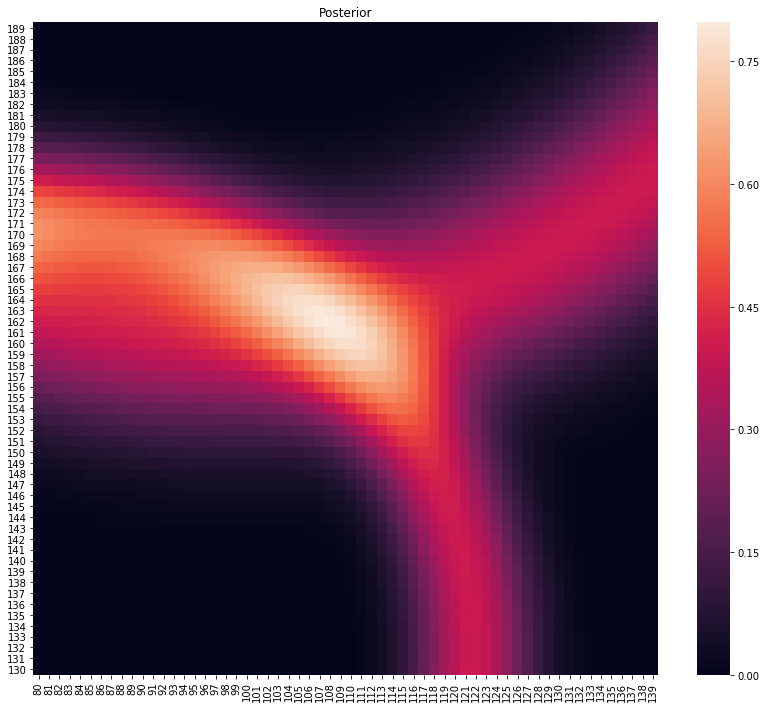

Location at (112, 158)


In [11]:
# let's see what 2 intersecting error circles looks like
p, lo = main(gps_data.head(2))
plot_posterior(p)
print(f"Location at {lo}")

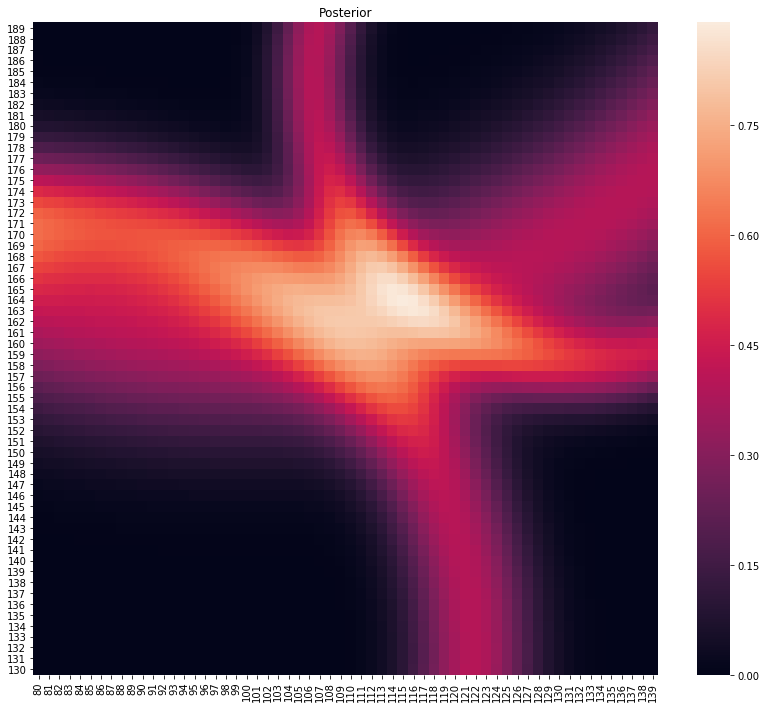

Location at (114, 165)


In [12]:
p, lo = main(gps_data.head(3))
plot_posterior(p)
print(f"Location at {lo}")

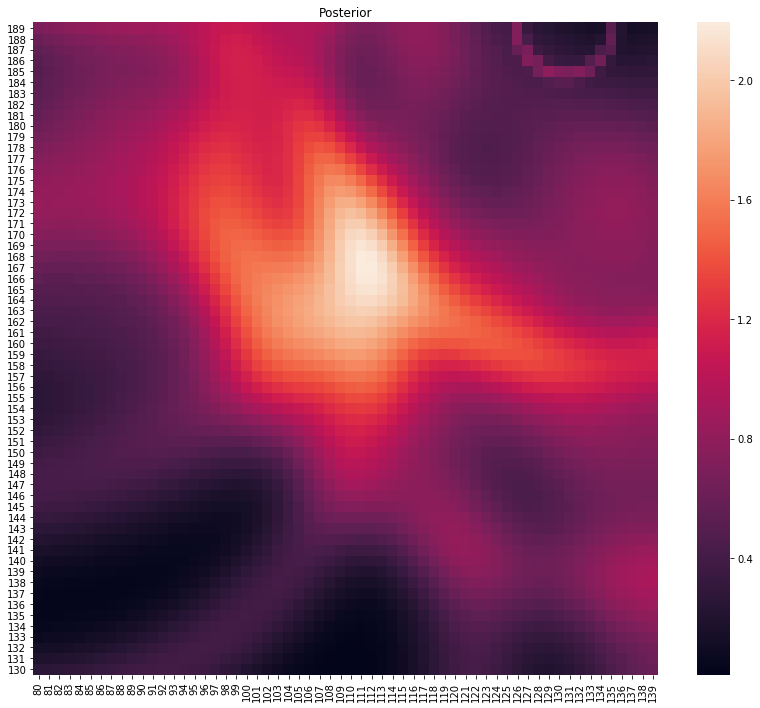

Location at (117, 162)


In [18]:
# note the outlier measurement in the top right
p, lo = main(gps_data.head(10))
plot_posterior(p)
print(f"Location at {lo}")

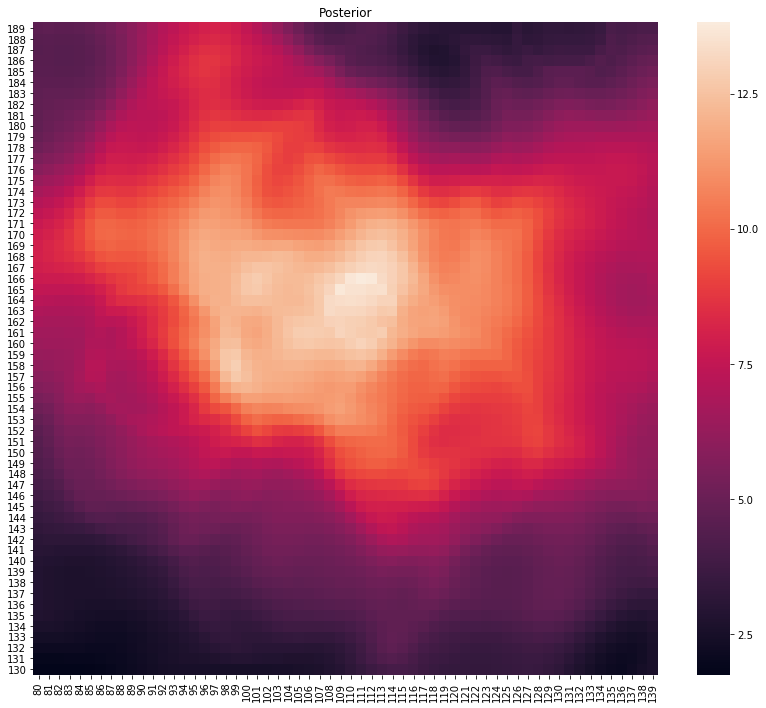

Location at (116, 161)


In [14]:
p, lo = main(gps_data.head(100))
plot_posterior(p)
print(f"Location at {lo}")

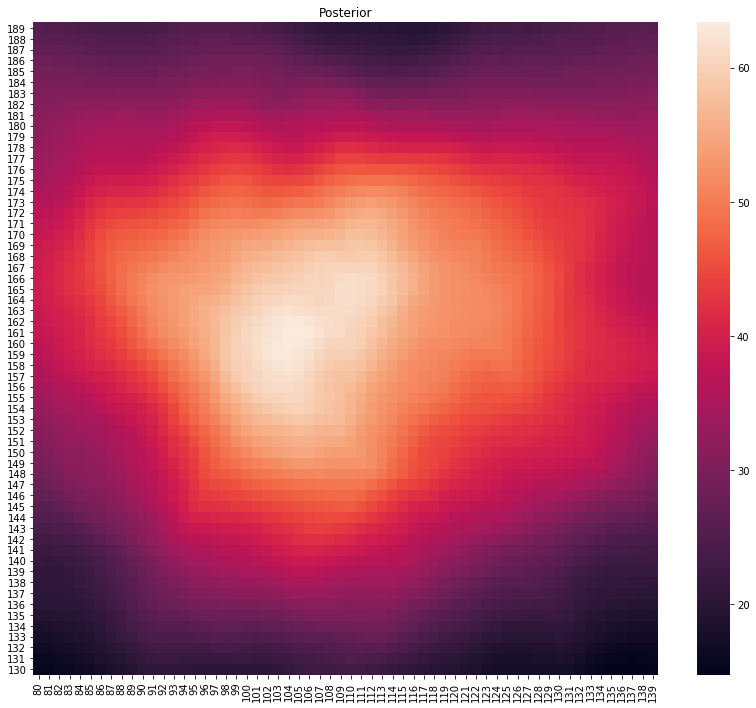

Location at (110, 154)


In [15]:
p, lo = main(gps_data.head(500))
plot_posterior(p)
print(f"Location at {lo}")

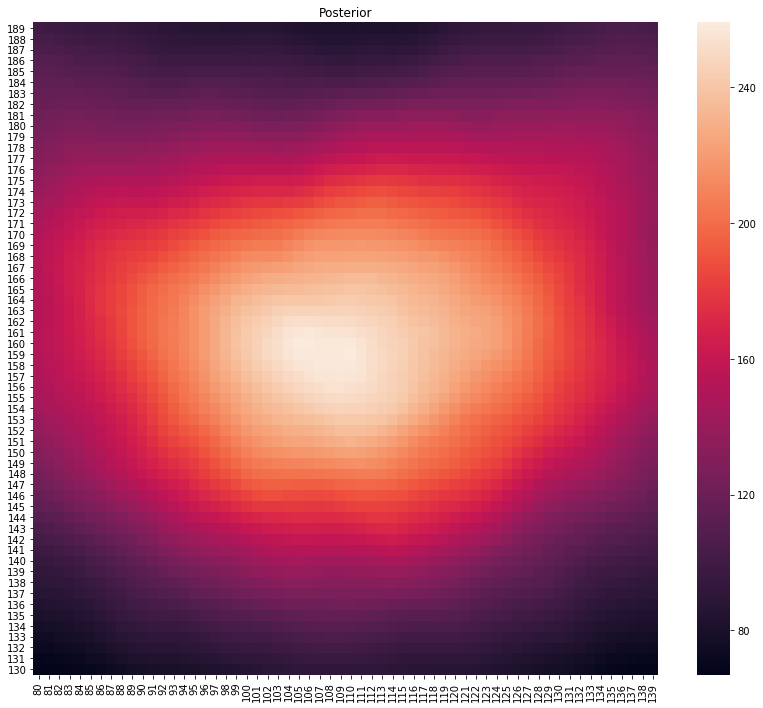

Location at (110, 156)


In [16]:
p, lo = main(gps_data)
plot_posterior(p)
print(f"Location at {lo}")

# Some Conclusions

## The Good
1. Bayesian Updating - the implementation allows for bayesian updating - we could calculate the posterior on disjoint sample sets and combine. This is nice since we can calculate how our posterior changes on each observation for limited increase in computation. However the simplistic implementation in Python is not optimised for this.
2. Posterior - while the task was to return a single best fit value, we can actually use the posterior to do proper inference or to guide our search if it isn't at the most likely spot.
3. Multiple models of error on measurement possible - we have chosen a 10% sd error on the radius but could have chosen a constant value given more information on the measurement. We didn't model the error in location of x,y for simplicity as we can consider this as part of the error in our location
4. Robust performance with less data - with just 10 observations we've al- ready worked out (117, 162) as the MAP. Would allow fewer observations to get good inference.
5. Ability to handle noise - in a frequentist setting, we would see observations like the 9th one could throw off frequentist inference while a Bayesian approach is more robust to outliers

## Further Work
All in all this was a simplied approach chosen to simplify the mathematics and calculations as well as respect time already spent. We could try

1. Optimisation on Likelihood - we could have used automatic differentiation on the likelihood or even an analytic approach (it's not that complicated) and found the value y that maximises the Likelihood.
2. There are some similarities to Bayesian Filtering here (I initially considered Kalman Filters due to the inherent similarities) - perhaps we could improve the computational aspect using Bayesian Filtering theory. Fox et al suggests a few ideas worth further investigation.
3. Computation could be sped up by using a GPU approach on the grid search. This could be achieved by implementing the likelihood in tensorflow. Given the loops in python are the primary source of slowness, this could also be simplified with some better software engineering.
4. The informativeness of the priors can be improved significantly. For example, we could choose a fattish normal distribution instead of a uniform x,y. We could also set thetai to be more informative in that it was restricted to the region in the prior. This would mean measurements further away would be more informative as we didn't have to consider all 2π radians, only the arc that fit inside our prior
5. A full Bayesian approach. Everything is a distribution. This is a quasi frequentist construction with a last second Bayesian-esque inference approach thrown in. I considered simulating the distributions on all of the θi,di,xi, but decided simplicity and conciseness was best. For a smaller dataset, this may make more sense since even at N=100, the posterior is still quite noisy. This would require a full MCMC approach, with a a lot of simulation (8000 from the priors) and a lot of MCMC runs to get it going.